Product : https://www.sec.gov/Archives/edgar/data/1053092/000095010322011059/dp175719_424b2-u6806.htm

In [120]:
import numpy as np
import pandas as pd
import scipy.stats as st
import matplotlib.pyplot as plt
from datetime import date

In [121]:
# Dates
trade = date(2022, 6, 17)
valuation = date(2024, 6, 17)
maturity = date(2024, 6, 21)

# Observation dates
observation = [date(2022, 9, 19), date(2022, 12, 19), date(2023, 3, 17), date(2023, 6, 20), 
               date(2023, 9, 18), date(2023, 12, 18), date(2024, 3, 18), valuation]

# Autocall dates
autocall_obs = observation[1:7]

# Coupon payment dates
cpn_payment = [date(2022, 9, 22), date(2022, 12, 22), date(2023, 3, 22), date(2023, 6, 23), 
               date(2023, 9, 21), date(2023, 12, 21), date(2024, 3, 21), maturity]

In [122]:
# Get 5-year index data (from WSJ)
SX5E_df = pd.read_csv('SX5E.csv', usecols = [4])
SPX_df = pd.read_csv('SPX.csv', usecols = [4])
NDX_df = pd.read_csv('NDX.csv', usecols = [4])
USDEUR_df = pd.read_csv('USDEUR.csv', usecols = [4])

print(SX5E_df.shape)
print(SPX_df.shape)
print(NDX_df.shape)
print(USDEUR_df.shape)

(1256, 1)
(1256, 1)
(1256, 1)
(1256, 1)


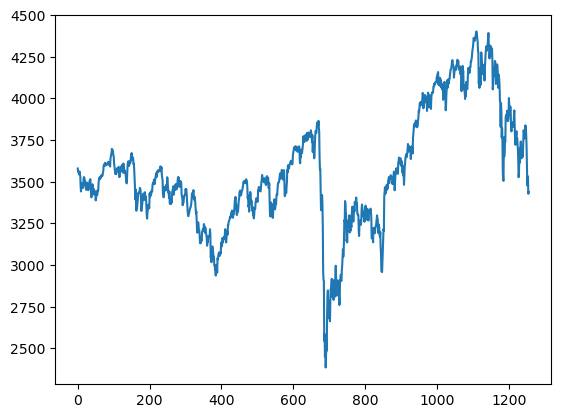

In [123]:
# Plot SX5E
plt.plot(SX5E_df[::-1].reset_index(drop=True))

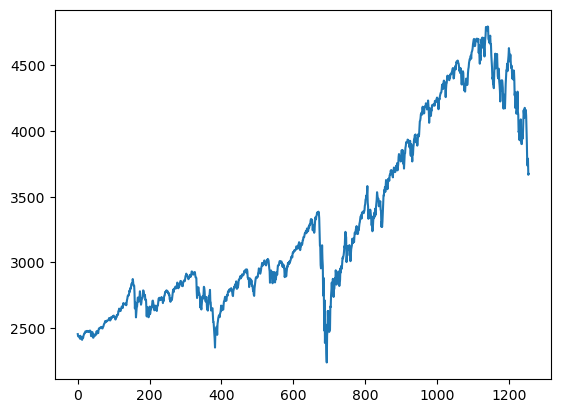

In [124]:
# Plot SPX
plt.plot(SPX_df[::-1].reset_index(drop=True))

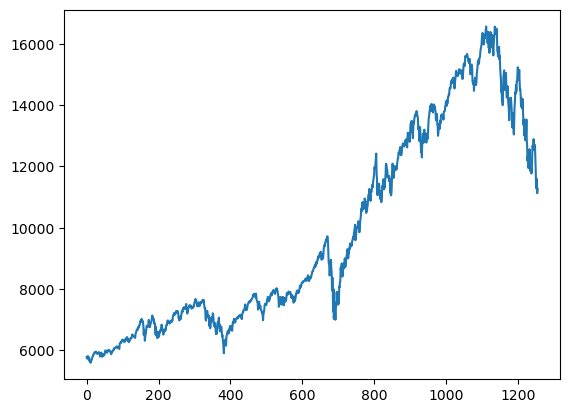

In [125]:
# Plot NDX
plt.plot(NDX_df[::-1].reset_index(drop=True))

In [126]:
# Calculate daily return
z = len(SX5E_df)
SX5E_df['Return'] = np.zeros(z)
SPX_df['Return'] = np.zeros(z)
NDX_df['Return'] = np.zeros(z)
USDEUR_df['Return'] = np.zeros(z)
var = 0

for i in range(1, z):
    SX5E_df['Return'][i] = (SX5E_df[' Close'][i] - SX5E_df[' Close'][i-1]) / SX5E_df[' Close'][i-1]
    SPX_df['Return'][i] = (SPX_df[' Close'][i] - SPX_df[' Close'][i-1]) / SPX_df[' Close'][i-1]
    NDX_df['Return'][i] = (NDX_df[' Close'][i] - NDX_df[' Close'][i-1]) / NDX_df[' Close'][i-1]
    USDEUR_df['Return'][i] = (USDEUR_df[' Close'][i] - USDEUR_df[' Close'][i-1]) / USDEUR_df[' Close'][i-1]
    var += USDEUR_df['Return'][i] ** 2 # for sigma_EU (exchange rate vol.) calculation

In [127]:
N = 100000 # Number of simulations
n_asset = 3 # Number of assets

# S0 initial index values
S10 = 3438.46 # SX5E
S20 = 3674.84 # SPX 
S30 = 11265.99 # NDX

# Barrier 65%
b1 = 2234.999 # SX5E
b2 = 2388.646 # SPX
b3 = 7322.8935 # NDX

# Principal amount
face = 1000

# Coupon payment (quarter)
cpn = 27

# Time (in terms of tau)
T = (valuation - trade).days / 365
dt = [(observation[0] - trade).days / 365] # delta t between observation dates
for i in range(1, len(observation)):
    dt.append((observation[i] - observation[i-1]).days / 365)

print(T)
print(dt)

2.0027397260273974
[0.25753424657534246, 0.2493150684931507, 0.2410958904109589, 0.2602739726027397, 0.2465753424657534, 0.2493150684931507, 0.2493150684931507, 0.2493150684931507]


In [128]:
## From Bloomberg
# Rate (with linear interpolation)
ois_US = ((date(2024, 6, 24) - valuation).days * 0.951158 + \
          (valuation - date(2023, 12, 22)).days * 0.934924) / \
         (date(2024, 6, 24) - date(2023, 12, 22)).days
ois_EU = ((date(2024, 6, 21) - valuation).days * 0.979875 + \
          (valuation - date(2023, 12, 21)).days * 0.968661) / \
         (date(2024, 6, 21) - date(2023, 12, 21)).days

r_US = -np.log(ois_US) / T # 0.03327104161392691
r_EU = -np.log(ois_EU) / T # 0.015772174573433134

# Sigma
sigma1 = [.27554, .26016, .25223, .23313, .22764, .21591, 
          .65210, .49430, .42732, .35922, .32929, .30529] # SX5E vol.
sigma2 = [.27259, .26562, .26293, .25469, .24833, .24056,
          .64709, .49777, .43505, .37973, .35033, .33137] # SPX vol. 
sigma3 = [.34800, .33809, .32524, .31801, .30691, .30120,
          .54724, .51857, .46330, .40390, .37266, .35351] # NDX vol.
sigma_EU = np.sqrt(var / (len(USDEUR_df) - 1)) # USDEUR exchange rate vol.

# Rho
rho12 = SX5E_df['Return'].corr(SPX_df['Return']) # SX5E SPX 
rho23 = SPX_df['Return'].corr(NDX_df['Return']) # SPX NDX 
rho13 = SX5E_df['Return'].corr(NDX_df['Return']) # SX5E NDX 
rho_EU = USDEUR_df['Return'].corr(SX5E_df['Return']) # USDEUR SX5E

# Dividend
q1 = 0.01886 # SX5E
q2 = 0.01839 # SPX
q3 = 0.01015 # NDX

print(sigma_EU)
print(rho12, rho23, rho13, rho_EU)

0.0042977240910584335
0.6076058166294225 0.9290546258801048 0.4998145228326834 -0.02690258716796366


In [129]:
# Vectorize all inputs
S0 = [S10, S20, S30]
b = [b1, b2, b3]
q = [q1, q2, q3]
sigma = [sigma1[4], sigma2[5], sigma3[5]] # cherry picking for vol. inputs
rho = [[1, rho12, rho13], [rho12, 1, rho23], [rho13, rho23, 1]]

In [130]:
# Cholesky decomposition (for diffusion term)
cholesky = np.linalg.cholesky(rho)
cholesky

array([[1.        , 0.        , 0.        ],
       [0.60760582, 0.79423874, 0.        ],
       [0.49981452, 0.78737587, 0.36086658]])

In [131]:
# Discount factor for each cpn payment date to valuation date
cpn2valuation = [np.exp(r_US * (valuation - i).days / 365) for i in cpn_payment]
cpn2valuation

[1.0594939023720018,
 1.050741779588085,
 1.042156947110936,
 1.0333596331355257,
 1.0249168172968004,
 1.0164503241832485,
 1.0080537699217402,
 0.9996354523089896]

In [132]:
# Coupon calculation
def CPN(cpn_path):
    return np.matmul(cpn_path, cpn2valuation) * cpn

In [133]:
def monte():

    result = []

    for _ in range(10): # trials

        V = np.zeros(N)
        drift = np.zeros(n_asset)
        
        for i in range(N): # simulations
            
            St = np.zeros(n_asset) # simulated price on observation date t
            pre_St = np.array(S0) # previous simulated price on last observation date t-1
            cpn_path = np.ones(len(observation)) # vector storing if coupon paid on observation dates
            called = False
            called_date = -1. # store the redemption date
            
            for t in range(len(observation)): # time steps
                
                if called:
                    for j in range(t, len(observation)):
                        cpn_path[j] = 0
                    break

                else:

                    phi = []
                    for _ in range(n_asset):
                        phi.append(np.random.normal(0, 1))
                    diffusion = np.matmul(cholesky, phi)

                    for j in range(n_asset):

                        if j == 0:
                            drift[j] = (r_EU - q[j] - rho_EU * sigma[j] * sigma_EU - 0.5 * sigma[j]**2) * dt[t]
                        else:
                            drift[j] = (r_US - q[j] - 0.5 * sigma[j]**2) * dt[t]

                        St[j] = pre_St[j] * np.exp(drift[j] + sigma[j] * diffusion[j] * np.sqrt(dt[t]))

                        if St[j] < b[j]: # check contingent cpn
                            cpn_path[t] = 0

                    if observation[t] in autocall_obs: # check auto-call
                        if (St[0] >= S0[0]) and (St[1] >= S0[1]) and (St[2] >= S0[2]):
                            called = True
                            called_date = t

                    pre_St = St
            
            if called:
                V[i] = face * np.exp(r_US * (valuation - observation[called_date]).days / 365) + CPN(cpn_path)
            
            else:
                if cpn_path[-1] == 1: # if each St at valuation date above barrier
                    V[i] = face + CPN(cpn_path)
                else: # if knock-in occurred
                    performance_factor = min([(St[i] - S0[i]) / S0[i] for i in range(n_asset)])
                    V[i] = face * (1 + performance_factor) + CPN(cpn_path)

            V[i] = V[i] * np.exp(-r_US * T)
        
        Simulated_Value = np.sum(V) / N
        result.append({'Simulations': N, 'Monte': Simulated_Value})
    
    return result

In [134]:
# Simulation values using data of 5 year horizon
MC_5y = monte()

In [135]:
# Getting 3-year data
idx_3y = 754
rho12 = SX5E_df['Return'][:idx_3y].corr(SPX_df['Return'][:idx_3y]) # SX5E SPX 
rho23 = SPX_df['Return'][:idx_3y].corr(NDX_df['Return'][:idx_3y]) # SPX NDX 
rho13 = SX5E_df['Return'][:idx_3y].corr(NDX_df['Return'][:idx_3y]) # SX5E NDX 
rho_EU = USDEUR_df['Return'][:idx_3y].corr(SX5E_df['Return'][:idx_3y]) # USDEUR SX5E

rho = [[1, rho12, rho13], [rho12, 1, rho23], [rho13, rho23, 1]]

var = 0
for i in range(idx_3y):
    var += USDEUR_df['Return'][i] ** 2
sigma_EU = np.sqrt(var / (len(USDEUR_df[:idx_3y]) - 1))

print(rho12, rho23, rho13, rho_EU, sigma_EU)

0.6325627332434557 0.9296160944085897 0.5245429904269903 -0.07422729371000213 0.004299344548992525


In [136]:
cholesky = np.linalg.cholesky(rho)
cholesky

array([[1.        , 0.        , 0.        ],
       [0.63256273, 0.77450913, 0.        ],
       [0.52454299, 0.7718563 , 0.35929446]])

In [137]:
# Simulation values using data of 3 year horizon
MC_3y = monte()

In [138]:
# Getting 1-year data
idx_1y = 252
rho12 = SX5E_df['Return'][:idx_1y].corr(SPX_df['Return'][:idx_1y]) # SX5E SPX 
rho23 = SPX_df['Return'][:idx_1y].corr(NDX_df['Return'][:idx_1y]) # SPX NDX 
rho13 = SX5E_df['Return'][:idx_1y].corr(NDX_df['Return'][:idx_1y]) # SX5E NDX 
rho_EU = USDEUR_df['Return'][:idx_1y].corr(SX5E_df['Return'][:idx_1y]) # USDEUR SX5E

rho = [[1, rho12, rho13], [rho12, 1, rho23], [rho13, rho23, 1]]

var = 0
for i in range(idx_1y):
    var += USDEUR_df['Return'][i] ** 2
sigma_EU = np.sqrt(var / (len(USDEUR_df[:idx_1y]) - 1))

print(rho12, rho23, rho13, rho_EU, sigma_EU)

0.5163405592565018 0.9516711979816761 0.44384142305010504 -0.27480959748321854 0.004543142658537994


In [139]:
cholesky = np.linalg.cholesky(rho)
cholesky

array([[1.        , 0.        , 0.        ],
       [0.51634056, 0.85638334, 0.        ],
       [0.44384142, 0.84366175, 0.302059  ]])

In [140]:
# Simulation values using data of 1 year horizon
MC_1y = monte()

In [141]:
df_1y = pd.DataFrame.from_dict(MC_1y)
df_3y = pd.DataFrame.from_dict(MC_3y)
df_5y = pd.DataFrame.from_dict(MC_5y)

In [142]:
df_1y

,Simulations,Monte
0,100000,976.640892
1,100000,975.789782
2,100000,976.621568
3,100000,975.899005
4,100000,976.471005
5,100000,975.420972
6,100000,976.480209
7,100000,977.013983
8,100000,976.260140
9,100000,976.024787


In [143]:
df_3y

,Simulations,Monte
0,100000,977.755968
1,100000,977.403001
2,100000,977.271922
3,100000,977.942355
4,100000,977.593990
5,100000,978.544490
6,100000,977.402286
7,100000,977.537811
8,100000,977.148652
9,100000,977.502357


In [144]:
df_5y

,Simulations,Monte
0,100000,977.434251
1,100000,977.637798
2,100000,976.466137
3,100000,976.605641
4,100000,976.174772
5,100000,976.665491
6,100000,976.964248
7,100000,976.304823
8,100000,975.734033
9,100000,976.373351


In [147]:
df_1y['Monte'].mean()

976.262234350751

In [146]:
df_3y['Monte'].mean()

977.610283324829

In [148]:
df_5y['Monte'].mean()

976.6360544528173